In [4]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image

import torch.nn.functional as F
from torchvision.datasets import ImageFolder
import torchvision.transforms as tf
import torchvision.datasets as tfds
import torchvision
from torchvision.transforms import ToPILImage

In [5]:
imgfolder = ImageFolder('./COVID-19_Radiography_Database/images/',
                       transform=tf.Compose([tf.Resize((224,224)),
                                             tf.Normalize(0,1),
                                             tf.ToTensor(),
                                            ]))

In [6]:
imgfolder

Dataset ImageFolder
    Number of datapoints: 2905
    Root location: ./COVID-19_Radiography_Database/images/
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=PIL.Image.BILINEAR)
               Normalize(mean=0, std=1)
               ToTensor()
           )

In [9]:
from torch.utils.data import Subset

In [7]:
from sklearn.model_selection import train_test_split

In [12]:
def train_val_dataset(dataset, val_split=0.25):
    train_idx, val_idx = train_test_split(list(range(len(dataset))), test_size=val_split)
    datasets = {}
    datasets['train'] = Subset(dataset, train_idx)
    datasets['val'] = Subset(dataset, val_idx)
    return datasets


In [13]:
print(len(imgfolder))
datasets = train_val_dataset(imgfolder)
print(len(datasets['train']))
print(len(datasets['val']))
# The original dataset is available in the Subset class
print(datasets['train'].dataset)

2905
2178
727
Dataset ImageFolder
    Number of datapoints: 2905
    Root location: ./COVID-19_Radiography_Database/images/
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=PIL.Image.BILINEAR)
               Normalize(mean=0, std=1)
               ToTensor()
           )


AttributeError: 'Subset' object has no attribute 'targets'

In [21]:
x = datasets['train'].targets

AttributeError: 'Subset' object has no attribute 'targets'

In [18]:
x = datasets['val'].dataset.targets

In [19]:
d = {}
for i in x:
    if i in d.keys():
        d[i] += 1
    else:
        d[i] = 1

In [20]:
d

{0: 219, 1: 1341, 2: 1345}

In [148]:
x = list(imgfolder.class_to_idx.keys())

In [149]:
x

['COVID-19', 'NORMAL', 'Viral Pneumonia']

In [150]:
{i:j for i,j in zip(x, d.values())}

{'COVID-19': 219, 'NORMAL': 1341, 'Viral Pneumonia': 1345}

In [297]:
dataset_loader = torch.utils.data.DataLoader(train_set,
                                             batch_size=16, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_set,
                                             batch_size=16, shuffle=False)

In [252]:
inpt, label  = next(iter(val_loader))

In [306]:
inpt.min()

tensor(0.)

In [253]:
label

tensor([1, 1, 1, 0, 2, 1, 1, 2, 1, 1, 2, 1, 0, 1, 2, 2])

In [244]:
inpt.shape

torch.Size([16, 3, 224, 224])

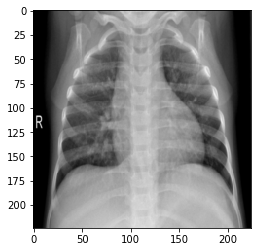

In [183]:
plt.imshow(inpt[4].permute(1,2,0))

In [184]:
def show(img):
    plt.imshow(img.permute(1,2,0))

In [185]:
def show(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')

In [186]:
label

tensor([2, 1, 1, 2, 2, 1, 2, 1, 2, 2, 1, 1, 2, 1, 1, 2])

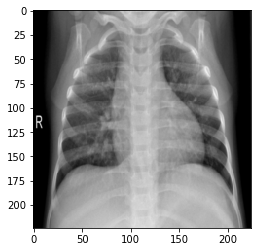

In [187]:
show(inpt[4])

In [210]:
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 7, stride=2, padding=3,) #512
        torch.nn.init.kaiming_normal_(self.conv1.weight)
        self.bn1 = nn.BatchNorm2d(16)
        
        self.conv2 = nn.Conv2d(16, 32, 3, stride=2, padding=1) #256
        torch.nn.init.kaiming_normal_(self.conv2.weight)
        self.bn2 = nn.BatchNorm2d(32)
        
        self.conv3 = nn.Conv2d(32, 64, 3, stride=2, padding=1) #128
        torch.nn.init.kaiming_normal_(self.conv3.weight)
        self.bn3 = nn.BatchNorm2d(64)
        
        self.conv4 = nn.Conv2d(64, 128, 3, stride=2, padding=1) #64
        torch.nn.init.kaiming_normal_(self.conv4.weight)
        self.bn4 = nn.BatchNorm2d(128)
        self.flatten = nn.Flatten()

        
        self.fc1 = nn.Linear(14*14*128, 120)  # 6*6 from image dimension
        torch.nn.init.kaiming_normal_(self.fc1.weight)
        self.fc2 = nn.Linear(120, 84)
        torch.nn.init.kaiming_normal_(self.fc2.weight)
        self.fc3 = nn.Linear(84, 10)
        torch.nn.init.kaiming_normal_(self.fc3.weight)
        self.fc4 = nn.Linear(10,3)
        torch.nn.init.kaiming_normal_(self.fc4.weight)

    def forward(self, x):
        x = F.relu(F.avg_pool2d(self.bn1(self.conv1(x)),3,1,1))
        x = F.relu(F.avg_pool2d(self.bn2(self.conv2(x)),3,1,1))
        x = F.relu(F.avg_pool2d(self.bn3(self.conv3(x)),3,1,1))
        x = F.relu(F.avg_pool2d(self.bn4(self.conv4(x)),3,1,1))
        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        x = F.softmax(x)
        return x



net = Net()

In [300]:
import torch.optim as optim


criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr = 0.001 )

In [301]:
for epoch in range(10):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(dataset_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        
        # print statistics
        running_loss += loss.item()
        if i % 19 == 0:    # print every 20 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 20))
            running_loss = 0.0
            
            with torch.no_grad():
                i = 0
                val_loss = 0.0
                for i, data in enumerate(val_loader):
                    i+=1
                    inpt, label = data
                    output = net(inpt)
                    loss = criterion(output, label)
                    val_loss+=loss

                print(f'validation loss {val_loss/i:.3f}')
                
            

print('Finished Training')

/Users/justintennenbaum/opt/anaconda3/envs/facial_rec/lib/python3.7/site-packages/ipykernel_launcher.py:42: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


[1,     1] loss: 0.053
validation loss 0.976
[1,    20] loss: 1.060
validation loss 1.061
[1,    39] loss: 1.064
validation loss 1.061
[1,    58] loss: 0.999
validation loss 1.061
[1,    77] loss: 1.036
validation loss 1.061
[1,    96] loss: 1.043
validation loss 1.061
[1,   115] loss: 1.002
validation loss 1.061
[1,   134] loss: 1.058
validation loss 1.061
[1,   153] loss: 1.064
validation loss 1.061
[2,     1] loss: 0.043
validation loss 1.061
[2,    20] loss: 1.030
validation loss 1.061
[2,    39] loss: 1.052
validation loss 1.061
[2,    58] loss: 1.027
validation loss 1.061
[2,    77] loss: 1.027
validation loss 1.061
[2,    96] loss: 1.039
validation loss 1.061
[2,   115] loss: 1.064
validation loss 1.061
[2,   134] loss: 1.043
validation loss 1.061
[2,   153] loss: 1.068
validation loss 1.061
[3,     1] loss: 0.056
validation loss 1.061
[3,    20] loss: 1.030
validation loss 1.061


KeyboardInterrupt: 

In [ ]:
net.

In [216]:
output = net(inpt)

/Users/justintennenbaum/opt/anaconda3/envs/facial_rec/lib/python3.7/site-packages/ipykernel_launcher.py:42: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


In [222]:
output

tensor([[4.4902e-03, 3.6973e-01, 6.2578e-01],
        [1.0402e-02, 7.5498e-01, 2.3462e-01],
        [6.0290e-03, 9.8291e-01, 1.1060e-02],
        [6.4989e-04, 8.5617e-02, 9.1373e-01],
        [7.2910e-03, 8.1491e-01, 1.7780e-01],
        [2.7913e-02, 9.4693e-01, 2.5159e-02],
        [3.4130e-03, 1.2104e-02, 9.8448e-01],
        [3.1074e-03, 7.9538e-01, 2.0151e-01],
        [8.1236e-04, 1.7066e-01, 8.2852e-01],
        [7.7031e-03, 1.5462e-01, 8.3768e-01],
        [1.1995e-02, 9.7563e-01, 1.2373e-02],
        [1.9224e-02, 9.6353e-01, 1.7244e-02],
        [2.0464e-03, 4.9076e-01, 5.0720e-01],
        [1.5033e-02, 6.8847e-01, 2.9650e-01],
        [4.0357e-02, 9.4696e-01, 1.2679e-02],
        [1.0973e-03, 5.2770e-02, 9.4613e-01]], grad_fn=<SoftmaxBackward>)

In [293]:
inpt, label = next(iter(val_loader))

In [294]:
x = []
total = 0
for i in output:
    x.append(list(i).index(max(i)))
for i,j in zip(x,label):
    if i == j:
        total +=1
        
x, label, total/16

([2, 1, 1, 2, 1, 1, 2, 1, 2, 2, 1, 1, 2, 1, 1, 2],
 tensor([2, 1, 2, 1, 2, 1, 1, 2, 2, 1, 1, 2, 2, 1, 0, 2]),
 0.5)

In [295]:
loss = criterion(output, label)

In [296]:
loss

tensor(1.0737, grad_fn=<NllLossBackward>)